In [ ]:
import sys
import os
import xarray
import openpyxl
import contextily as cx 
from matplotlib.offsetbox import AnchoredText
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean.cm as cm

In [ ]:
case='whidbey'
with open(f'../etc/SSM_config_{case}.yaml', 'r') as file:
        ssm = yaml.safe_load(file)
        # get shapefile path    
        shp = ssm['paths']['shapefile']
# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')       
netcdf_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/NO3/')

# load sum of surface salinity for all scenarios

In [ ]:
run_list = [*ssm['run_information']['run_tag']['whidbey']]
run_list

In [ ]:
param_select={}
for run_type in run_list:
    run_file = netcdf_dir/run_type/'surface'/'daily_sum_NO3_surface.nc'
    try: 
        with xarray.open_dataset(run_file) as ds:
            # there is only one variable in these files ([0]),
            # though the name changes; hence, [*ds]
            param_full=ds[[*ds][0]]
            # Sub-sample nodes (from 16012 nodes to 7494)
            param_select[run_type]=param_full[:,gdf['tce']-1]
            # Get number of days and nodes
            [ndays,nnodes]=param_select[run_type].shape
            print(f'Opened: {run_file}')
    except FileNotFoundError:
        print(f'File Not Found: {run_file}')

# Sum across nodes for each time step

In [ ]:
regional_sum={}
for run_type in run_list:
    regional_sum[run_type]={}
    for region in regions: 
        idx = ((gdf['Regions']==region) &
                (gdf['included_i']==1))
        # time series of noncompliant volume in regions for each day  
        regional_sum[run_type][region] = param_select[run_type][:,idx].sum(axis=1)
    print(run_type)


In [ ]:
regional_sum_difference={}
for run_type in run_list:
    regional_sum_difference[run_type]={}
    for region in regions:
        regional_sum_difference[run_type][region] = regional_sum[run_type][region]-regional_sum['wqm_baseline'][region]
    print(run_type)

In [ ]:
dti = np.arange(
        np.datetime64('2014-01-05'), np.datetime64('2015-01-01')
    )
dti.shape

In [ ]:
# graphic specifications.  I prefer to include these in a global file but haven't yet found a way to do that successfully on Hyak
# pushing the "easy" button
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

# dpi value to define quality and size of output graphic
dpi_mag=500

In [ ]:
run_list.remove('wqm_baseline')
run_list.remove('wqm_reference')
run_list

# Plot baseline

In [ ]:
for run in 'wqm_baseline': 
    fig, axs = plt.subplots(1,1, figsize = (10,5))
    for region in regions:
        axs.plot(dti,regional_sum_difference[run][region],
            color=ssm['region']['colors'][region],
            label=region,
            lw=2
        )
        axs.set_xlim(np.datetime64('2013-12-25'), np.datetime64('2014-12-31'))
        # set x-ticklabels to the 15th day of the month 
        axs.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=15))
        # set x-ticklabels to the first day of the month
        axs.xaxis.set_major_locator(mpl.dates.MonthLocator())
        axs.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))

    # Add text with scenario information to upper left corner 
    anchored_text = AnchoredText(
        ssm['run_information']['run_description_short'][case][run],
        loc='lower right',
        frameon=True,
        prop=dict(fontweight="normal",color="black")
    )
    if run in ['3c','3l','3m']:
        axs.set_ylim(-2000,2000)
    else:
        axs.set_ylim(-200, 20)
    axs.add_artist(anchored_text)     
    axs.set_ylabel(f'Total Dissolved Inorganic Nitrogen')
    axs.set_xlabel('Months in 2014')
    #axs.text(.1, .1, 'test')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    output_dir = pathlib.Path(ssm['paths']['graphics'])/'whidbey'
    plt.savefig(output_dir/f'Baseline_DIN_Total_by_regions_{run}.png', bbox_inches='tight', format='png', dpi=dpi_mag)

    

# Plot Scenarios

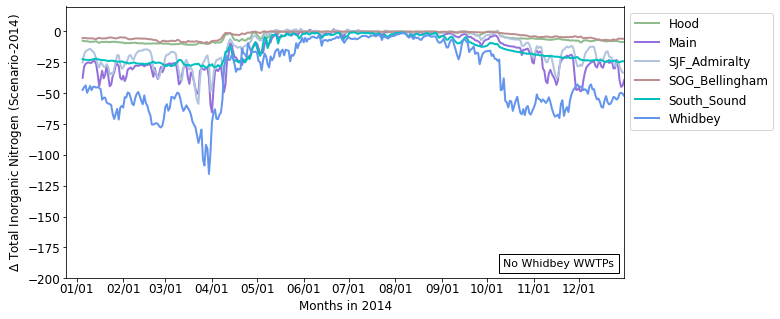

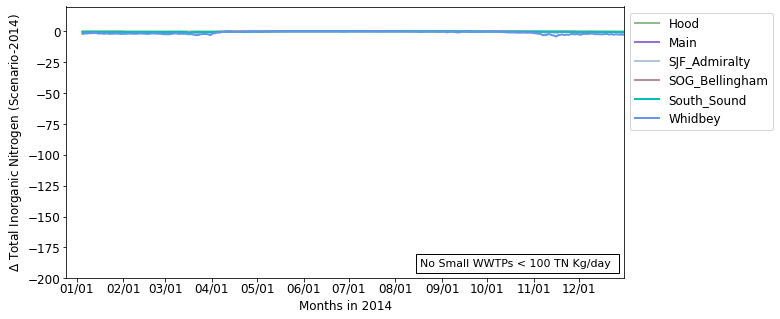

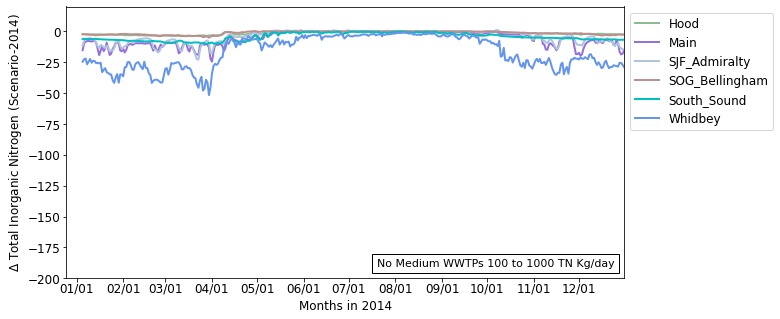

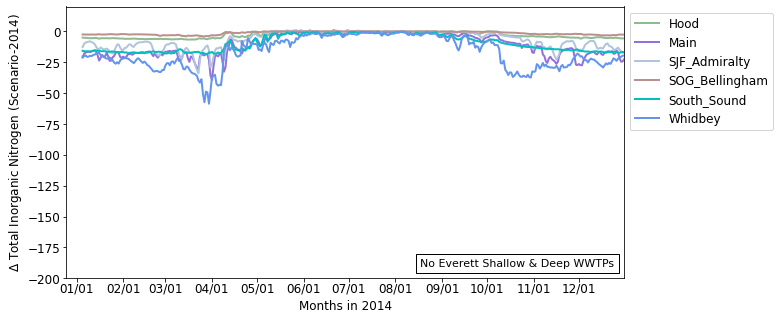

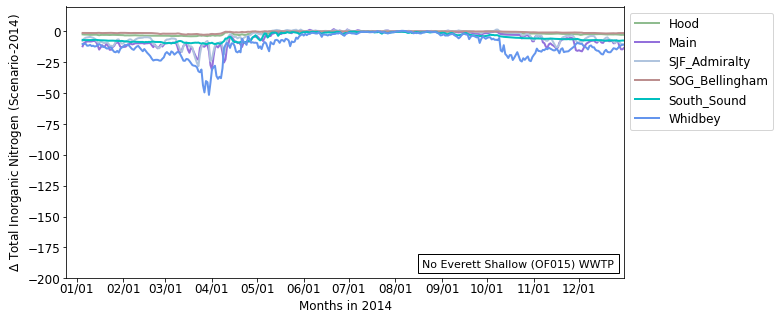

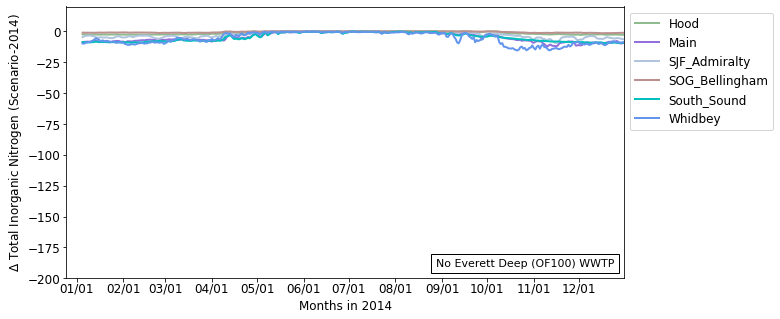

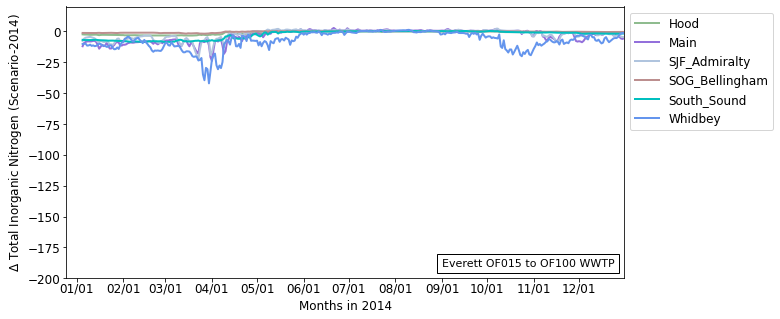

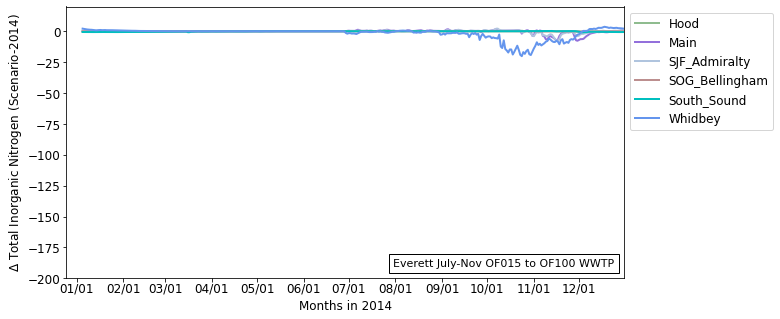

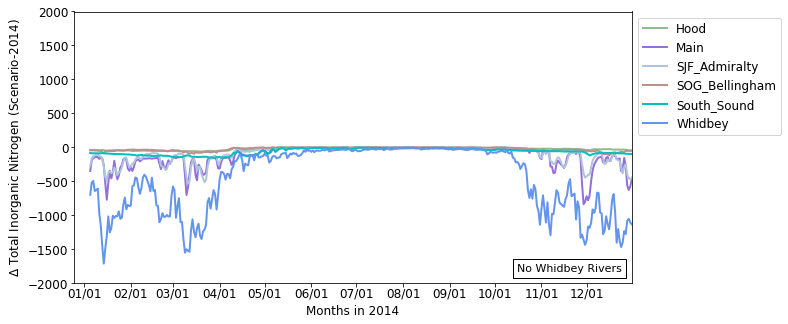

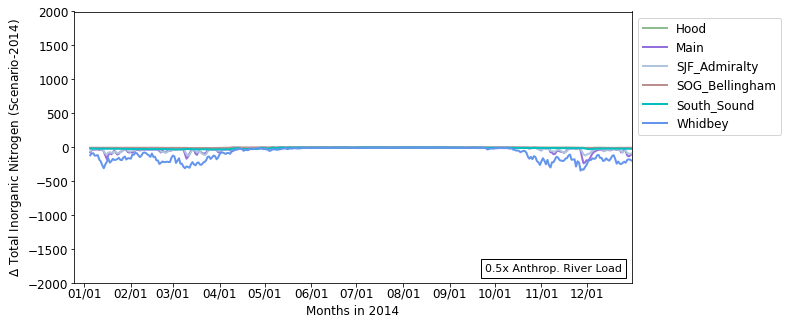

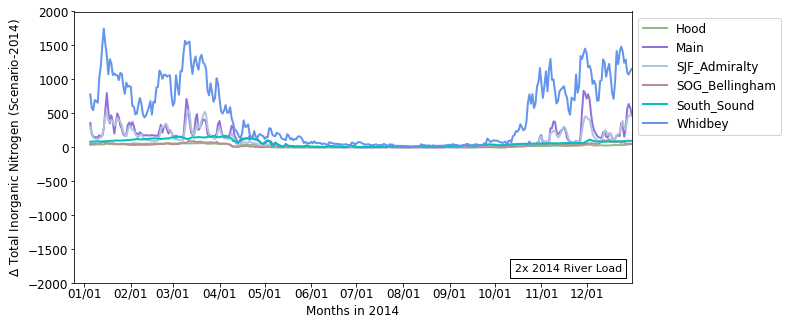

In [64]:
for run in run_list: 
    fig, axs = plt.subplots(1,1, figsize = (10,5))
    for region in regions:
        axs.plot(dti,regional_sum_difference[run][region],
            color=ssm['region']['colors'][region],
            label=region,
            lw=2
        )
        axs.set_xlim(np.datetime64('2013-12-25'), np.datetime64('2014-12-31'))
        # set x-ticklabels to the 15th day of the month 
        axs.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=15))
        # set x-ticklabels to the first day of the month
        axs.xaxis.set_major_locator(mpl.dates.MonthLocator())
        axs.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))

    # Add text with scenario information to upper left corner 
    anchored_text = AnchoredText(
        ssm['run_information']['run_description_short'][case][run],
        loc='lower right',
        frameon=True,
        prop=dict(fontweight="normal",color="black")
    )
    if run in ['3c','3l','3m']:
        axs.set_ylim(-2000,2000)
    else:
        axs.set_ylim(-200, 20)
    axs.add_artist(anchored_text)     
    axs.set_ylabel(f'$\Delta$ Total Inorganic Nitrogen (Scenario-2014)')
    axs.set_xlabel('Months in 2014')
    #axs.text(.1, .1, 'test')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    output_dir = pathlib.Path(ssm['paths']['graphics'])/'whidbey'
    plt.savefig(output_dir/f'Delta_DIN_by_regions_{run}.png', bbox_inches='tight', format='png', dpi=dpi_mag)

    

## Noncompliant

In [23]:
## Noncompliant
## -0.25 mg/l referenced on pp. 49 and 50 of Appendix F in Optimization Report
## https://www.ezview.wa.gov/Portals/_1962/Documents/PSNSRP/Appendices%20A-G%20for%20Tech%20Memo.pdf
noncompliant=-0.25

#this has potential to get really confusing!  
# The excel spreadsheets use the modified numbering, so I need to do some back-flips here.
# The keys (left) reflect "second draft" keys and map to Hyak run_ids (right).
# We need this map because the file names (intentionally) use Hyak run_ids
# while columns in spreadsheet are "report-ready"

excel_tag_map = {
    'Wtp1':'3b',    
    'Wtp2':'3e',
    'Wtp3':'3f',
    'Wtp4':'3g',
    'Wtp5':'3h',
    'Wtp6':'3i',
    'Wtp7':'3j',
    'Wtp8':'3k',
    'Wr1':'3c',
    'Wr2':'3l',
    'Wr3':'3m'
}

axis_dict = {
    'Wtp1':(0,0),
    'Wtp2':(1,0),
    'Wtp3':(2,0),
    'Wtp4':(3,0),
    'Wtp5':(4,0),
    'Wtp6':(5,0),
    'Wtp7':(6,0),
    'Wtp8':(7,0),
    'Wr1':(8,0),
    'Wr2':(9,0),
    'Wr3':(10,0)
}
plot_runs = [*axis_dict]

nruns = len(axis_dict)

# Convert noncompliant to text string to use in file name
non_compliant_txt = str(noncompliant)
non_compliant_txt = non_compliant_txt.replace('.','p')
non_compliant_txt = non_compliant_txt.replace('-','m')

# Create output directories if/as needed
graphics_dir = pathlib.Path(ssm['paths']['graphics'])/case
output_directory = graphics_dir/'noncompliance'/non_compliant_txt/f'{nruns}_panel'
output_directory_single = graphics_dir/'noncompliance'/non_compliant_txt/'single_graphics'

# directory of excel spreadsheets created by calc_noncompliance_timeseries
xlxs_dir=f"/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/{case}/spreadsheets/"
# 2014 conditions spreadsheet path (same as above but for this specific case)
baseline_path=f"/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/{case}/spreadsheets/{case}_baseline_wc_noncompliant_{non_compliant_txt}_TS_byRegion.xlsx"

In [13]:
# Select excel files in directory with .xlsx extension and non-complaiant_TS in name 
excel_files = (file for file in os.listdir(xlxs_dir) if (file.split('.')[-1]=='xlsx') & (file.__contains__(f'{non_compliant_txt}_TS')))

# Pull directory name from excel_scenario_path path
tsdf={}
for file in excel_files:   
    print('file:',file)
    # combine directory and path name for full path
    excel_scenario_path=pathlib.Path(xlxs_dir,file)
    # extract run_tag from filename
    print(str(excel_scenario_path))
    run_tag = str(excel_scenario_path).split('/')[-1].split('_')[1]
    print(run_tag)
    if (run_tag !='baseline'):
        # load the scenario timeseries spreadsheets
        tsdf[run_tag]=pandas.read_excel(excel_scenario_path)
        tsdf[run_tag]=tsdf[run_tag].drop('Unnamed: 0',axis=1)
        tsdf[run_tag]['date']=np.arange(
            np.datetime64('2014-01-05'), np.datetime64('2015-01-01')
        )
        tsdf[run_tag].set_index('date')
# load the baseline timeseries spreadsheet
ts_base_df=pandas.read_excel(baseline_path)    
ts_base_df=ts_base_df.drop('Unnamed: 0',axis=1)
ts_base_df['date']=np.arange(
    np.datetime64('2014-01-05'), np.datetime64('2015-01-01')
)
ts_base_df.set_index('date')
# load header information
readme=pandas.read_excel(
    excel_scenario_path, 
    sheet_name='README',
    index_col=0
)    

# create time array that reflects the removal of spin-up days
days = np.arange(
    tsdf[run_tag].shape[0])+ssm['run_information']['spin_up_days']

file: whidbey_Reference_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_Reference_wc_noncompliant_m0p25_TS_byRegion.xlsx
Reference
file: whidbey_baseline_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_baseline_wc_noncompliant_m0p25_TS_byRegion.xlsx
baseline
file: whidbey_Wtp1_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_Wtp1_wc_noncompliant_m0p25_TS_byRegion.xlsx
Wtp1
file: whidbey_Wtp8_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_Wtp8_wc_noncompliant_m0p25_TS_byRegion.xlsx
Wtp8
file: whidbey_Wr2_wc_noncompliant_m0p25_TS_byRegion.xlsx
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_Wr2_wc_noncompliant_m0p25_TS

### take scenario - 2014 difference

In [15]:
[*tsdf]

['Reference',
 'Wtp1',
 'Wtp8',
 'Wr2',
 'Wtp2',
 'Wtp6',
 'Wtp3',
 'Wtp5',
 'Wtp4',
 'Wr1',
 'Wr3',
 'Wtp7']

In [24]:
[*excel_tag_map]

['Wtp1',
 'Wtp2',
 'Wtp3',
 'Wtp4',
 'Wtp5',
 'Wtp6',
 'Wtp7',
 'Wtp8',
 'Wr1',
 'Wr2',
 'Wr3']

In [25]:
regional_noncomplaince_difference={}
for run_type in [*excel_tag_map]:
    print(run_type)
    regional_noncomplaince_difference[run_type]={}
    for region in regions:
        regional_noncomplaince_difference[run_type][region] = tsdf[run_type][region]-ts_base_df[region]

Wtp1
Wtp2
Wtp3
Wtp4
Wtp5
Wtp6
Wtp7
Wtp8
Wr1
Wr2
Wr3


In [26]:
[*regional_sum_difference]

['wqm_baseline',
 'wqm_reference',
 '3b',
 '3e',
 '3f',
 '3g',
 '3h',
 '3i',
 '3j',
 '3k',
 '3c',
 '3l',
 '3m']

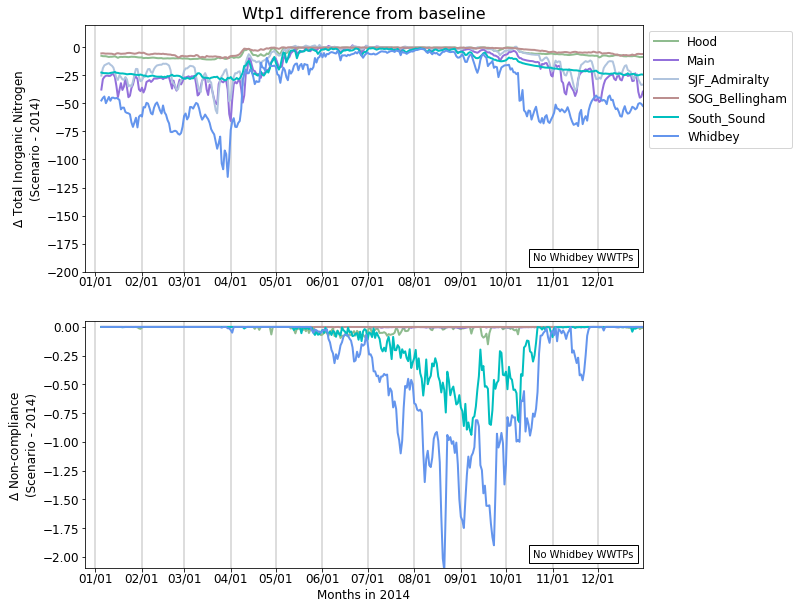

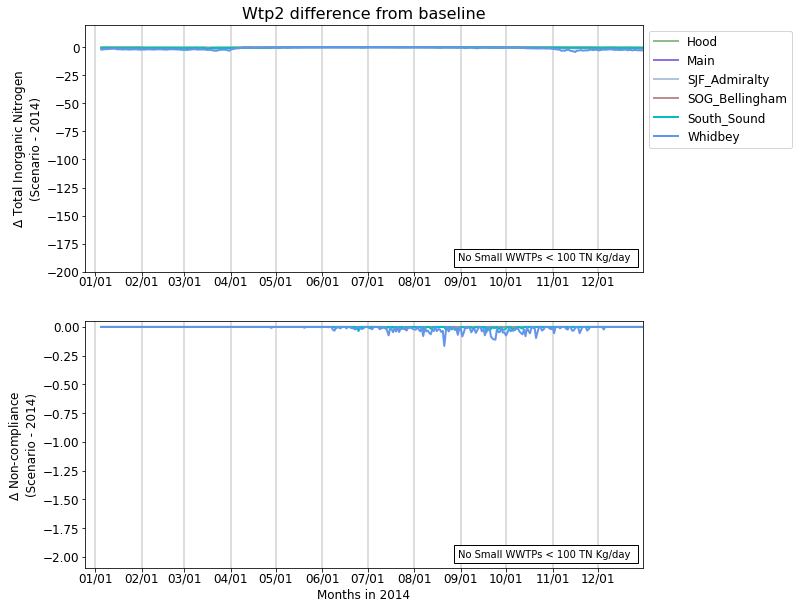

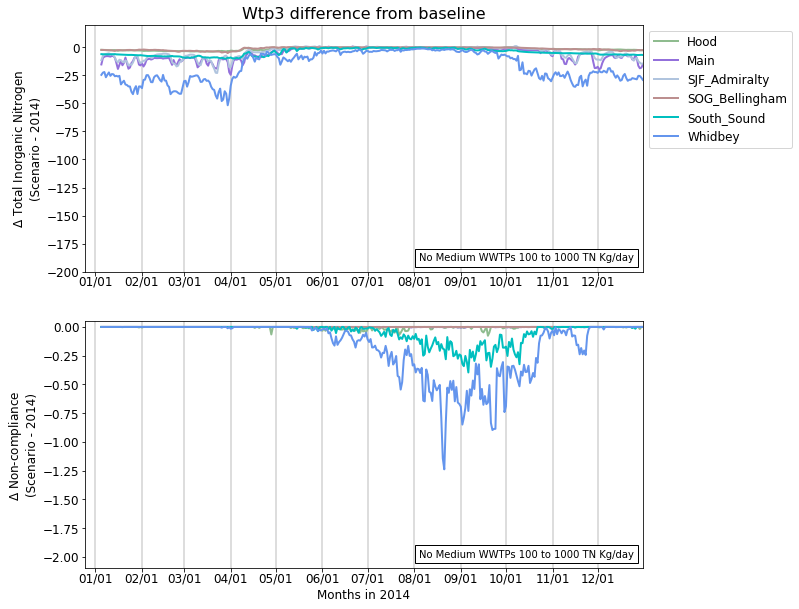

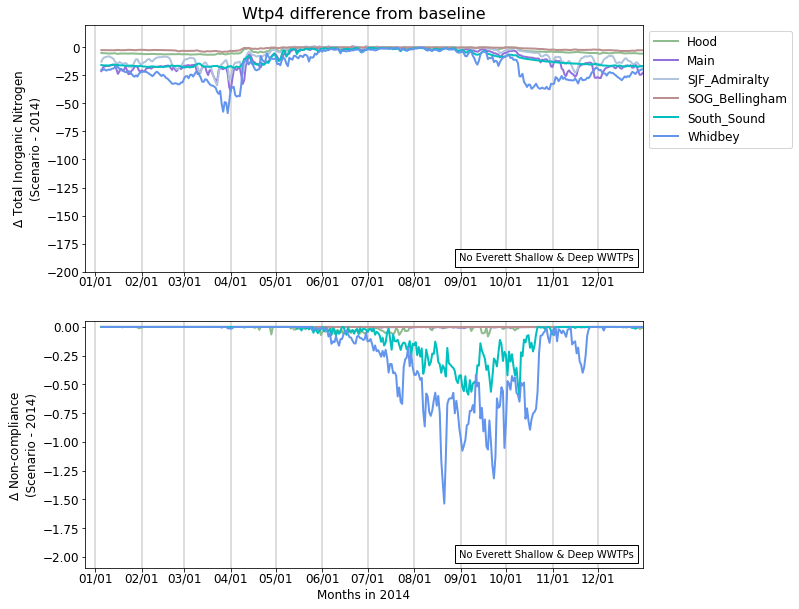

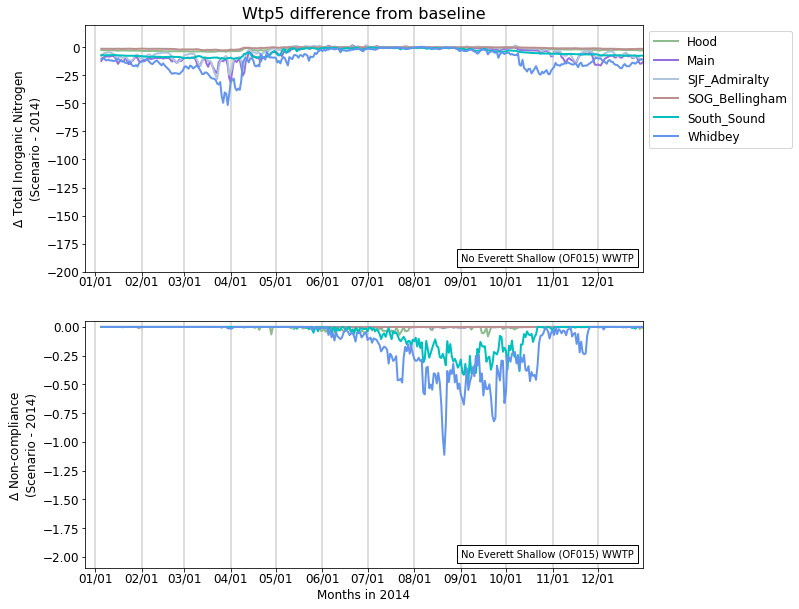

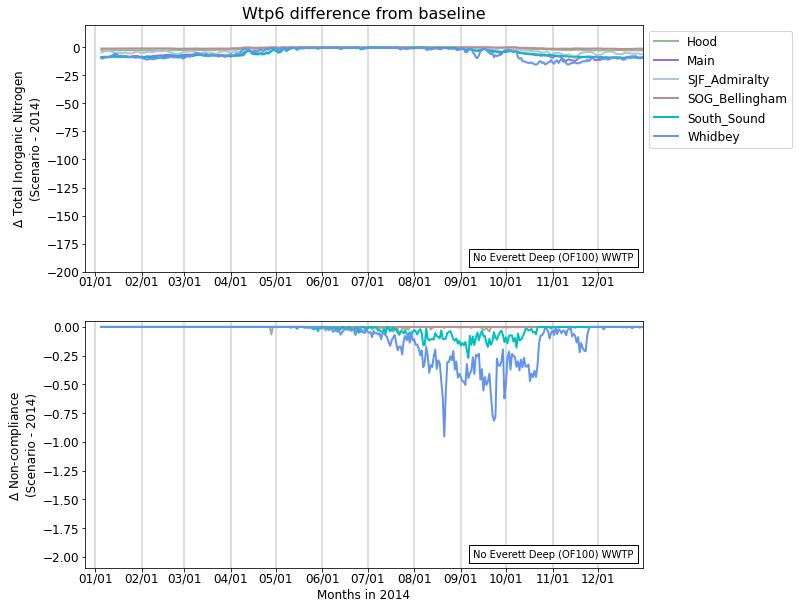

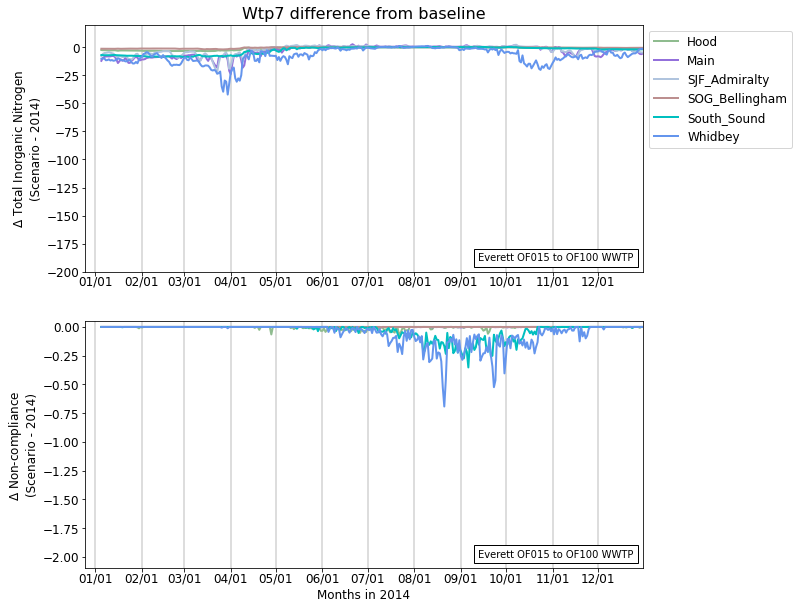

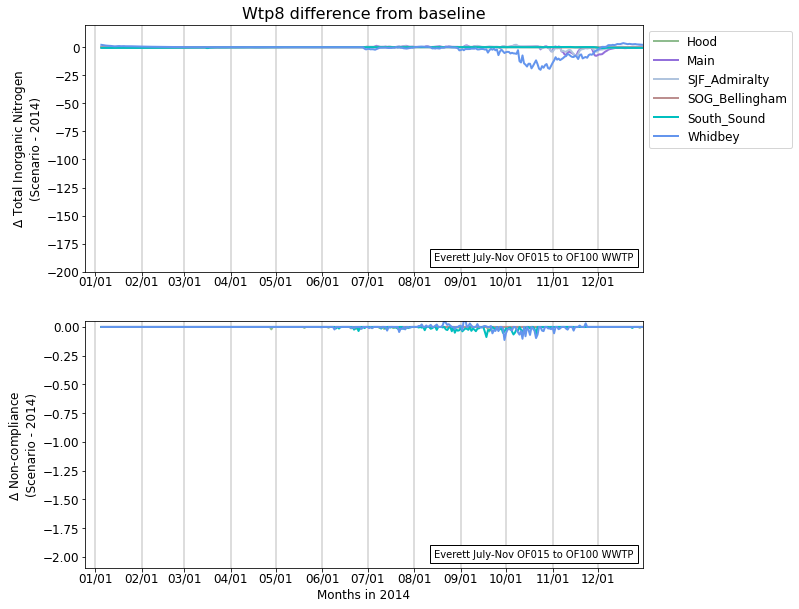

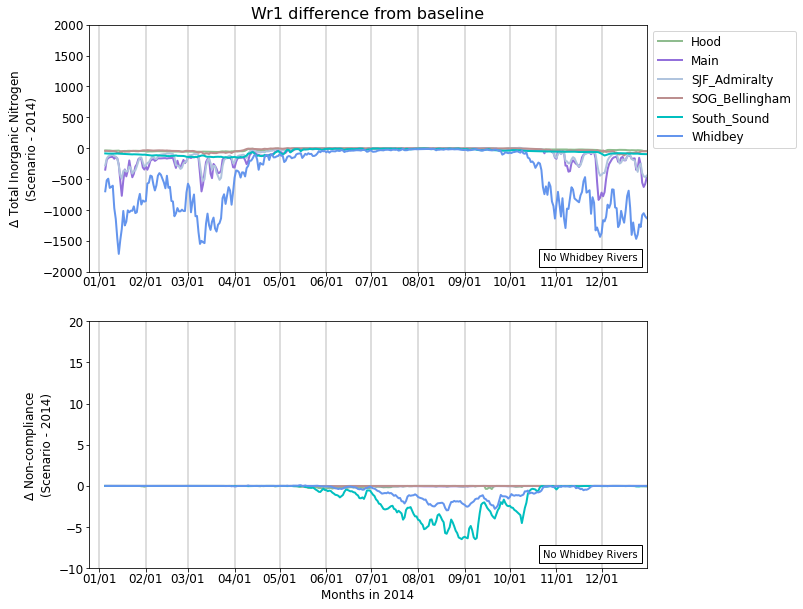

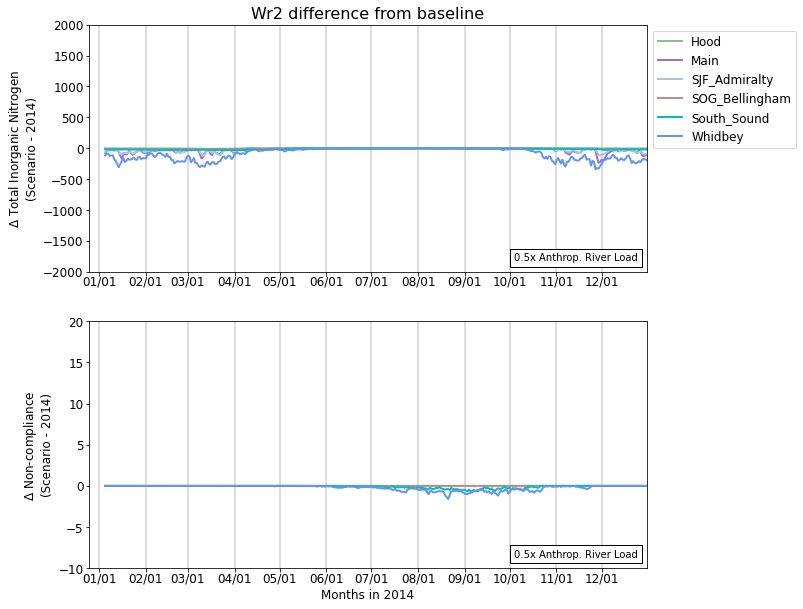

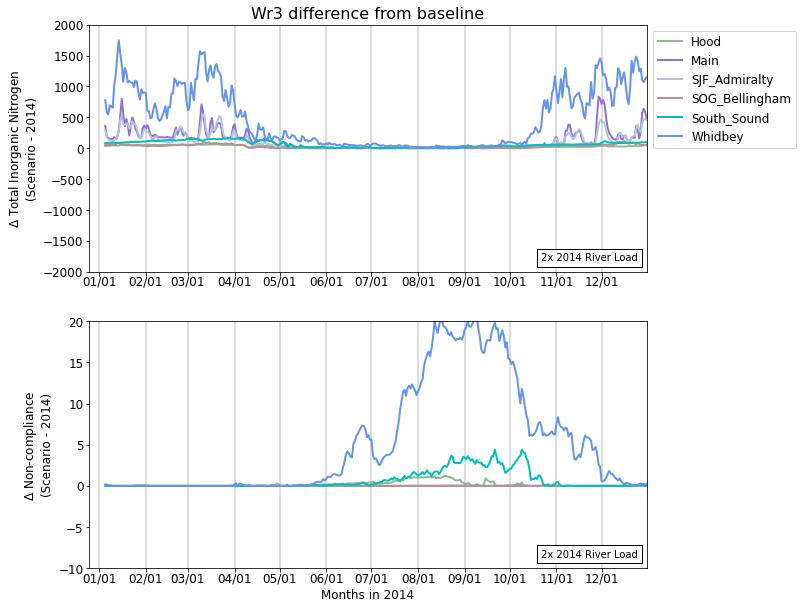

In [50]:
for run in [*excel_tag_map]: 
    fig, axs = plt.subplots(2,1, figsize = (10,10))
    for ind in [0,1]:
            axs[ind].set_xlim(np.datetime64('2013-12-25'), np.datetime64('2014-12-31'))
            # set x-ticklabels to the 15th day of the month 
            axs[ind].xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=15))
            # set x-ticklabels to the first day of the month
            axs[ind].xaxis.set_major_locator(mpl.dates.MonthLocator())
            axs[ind].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d'))

    # add vertical lines at months
    for date in [np.datetime64(f'2014-{month:02}-01') for month in np.arange(1,13)]:
        if run in ['Wr1','Wr2','Wr3']:
            axs[0].plot([date,date],[-2000,2000],color='lightgrey')
            axs[1].plot([date,date],[-10,20],color='lightgrey')

        else:
            axs[0].plot([date,date],[-200, 20],color='lightgrey')
            axs[1].plot([date,date],[-2.1,.05],color='lightgrey')

                
    for region in regions:
        axs[0].plot(dti,regional_sum_difference[excel_tag_map[run]][region],
            color=ssm['region']['colors'][region],
            label=region,
            lw=2
        )
        axs[1].plot(
            dti,
            regional_noncomplaince_difference[run][region],
            color=ssm['region']['colors'][region],
            #ls=ssm['bw_line']['style']['scenario'],
            lw=2,
            label=region           
        )
        
    # Add text with scenario information to upper left corner 
    anchored_text0 = AnchoredText(
        ssm['run_information']['run_description_short'][case][excel_tag_map[run]],
        loc='lower right',
        frameon=True,
        prop=dict(fontweight="normal",color="black")
    )
    anchored_text1 = AnchoredText(
        ssm['run_information']['run_description_short'][case][excel_tag_map[run]],
        loc='lower right',
        frameon=True,
        prop=dict(fontweight="normal",color="black")
    )
    axs[0].add_artist(anchored_text0)
    axs[1].add_artist(anchored_text1)
    # fix y-limits
    if run in ['Wr1','Wr2','Wr3']:
        axs[0].set_ylim(-2000,2000)
        axs[1].set_ylim(-10,20)
    else:
        axs[0].set_ylim(-200, 20)
        axs[1].set_ylim(-2.1,.05)
    axs[0].set_title(f'{run} difference from baseline')
    axs[0].set_ylabel(f'$\Delta$ Total Inorganic Nitrogen\n(Scenario - 2014)')
    axs[1].set_ylabel(f'$\Delta$ Non-compliance\n(Scenario - 2014)')
    axs[1].set_xlabel('Months in 2014')
    h1, l1 = axs[0].get_legend_handles_labels()
    h2, l2 = axs[1].get_legend_handles_labels()
    axs[0].legend(h1, l1, bbox_to_anchor=(1.0, 1.0), loc='upper left')
    #axs.text(.1, .1, 'test')
    #plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    
    output_dir = pathlib.Path(ssm['paths']['graphics'])/'whidbey'
    plt.savefig(output_dir/f'Delta_DIN_and_Noncompliance_by_regions_{run}.png', bbox_inches='tight', format='png', dpi=dpi_mag)

In [49]:
output_dir

PosixPath('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/whidbey')